<a href="https://colab.research.google.com/github/hyunj941031/ds-sa-cp2/blob/main/models/BERT4Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install python-box

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 parameter 설정

In [98]:
config = {
    'data_path' : '/content/drive/MyDrive/fashion_campus_dataset',
    'max_len' : 50,
    'hidden_units' : 500, # Embedding size
    'num_heads' : 2, # Multi-head layer 수 (병렬처리)
    'num_layers' : 3, # block 수 (encoder layer 수)
    'dropout_rate' : 0.4, # dropout의 비율
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 10,
    'num_workers' : 4,
    'mask_prob' : 0.5, # cloze task
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [99]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'user_item.csv'))

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('itemId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['itemId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따른 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col:str) -> dict:
        '''
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Return:
            dict: 생성된 user encoder, decoder
        '''

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id
        
        return encoder, decoder

    def generate_sequence_data(self) -> dict:
        '''
        sequence data 생성

        Return:
            dict: train user sequence / valid user sequence
        '''
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())

        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템 예측

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [100]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        return self.num_user

    def __getitem__(self, user):
        user_seq = self.user_train[user]
        tokens = []
        labels = []
        for s in user_seq[-self.max_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.2:
                    # masking
                    tokens.append(self.num_item + 1) # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.3:
                    # noise를 위한 neg item sampling
                    tokens.extend(self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1)) # item random sampling
                else:
                    tokens.append(s)
                labels.append(s) # 학습에 사용
            else:
                tokens.append(s)
                labels.append(0) # 학습에 사용 x
                
        mask_len = self.max_len - len(tokens)
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

# 3. 모델

In [101]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        '''
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        '''
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score. masked_fill(mask == 0, -1e9) # 유사도가 0인 지점은 -infinity로 보내서 softmax 결과가 0이 아니게 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1)) # attention distribution
        output = torch.matmul(attn_dist, V)
        return output, attn_dist

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_units = hidden_units

        # query, key value, output 생성을 위한 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6)

    def forward(self, enc, mask):
        '''
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        '''
        residual = enc # residual connection을 위한 residual 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist

class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output

class BERT4RecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(BERT4RecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist

class BERT4Rec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(BERT4Rec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 2, hidden_units, padding_idx=0) # padding : 0 / item : 1 ~ num_item + 1 /  mask : num_item + 2
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([BERT4RecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        self.out = nn.Linear(hidden_units, num_item + 1)
    
    def forward(self, log_seqs):
        """
        log_seqs : (batch_size, max_len)

        ex)
        log_seqs = [
                [1, 2, 3, 4, 5],
                [0, 0, 0, 1, 2],
                [0, 0, 1, 2, 3]
        ]
        
        """
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device)) # (batch_size, max_len, hidden_units)
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1]) # (batch_size, max_len)
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device)) # (batch_size, max_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs)) # LayerNorm

        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).repeat(1, log_seqs.shape[1], 1).unsqueeze(1).to(self.device) # mask for zero pad / (batch_size, 1, max_len, max_len)
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask_pad)
        out = self.out(seqs) # (batch_size, max_len, num_item + 1)
        return out

# 4. 학습함수

In [102]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, labels in data_loader:
        logits = model(seq)

        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1).to(device) # 같은 device에 들어가게끔

        optimizer.zero_grad() # 역전파 시, 루프마다 간섭을 하지 않게 하기 위해서 grad값들을 0으로 초기화
        loss = criterion(logits, labels)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, bert4rec_dataset, make_sequence_dataset):
    model.eval() # layer들의 동작을 inference(evaluation) mode로 바꿔주는 목적 -> BatchNorm 등

    NDCG = 0.0 # NDCG@10 / normalized discounted cumulative gain : 랭킹 결과의 길이에 상관없이 일정한 스케일을 갖도록 하는 normalize
    HIT = 0.0 # HIT@10 / 전체 사용자 수 대비 적중한 사용자 수

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in users:
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:]
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)

        with torch.no_grad(): # gradient를 트래킹하지 않음, 메모리 사용량을 줄이고 연산속도 향상
            predictions = -model(np.array([seq]))
            predictions = predictions[0][-1][items]
            rank = predictions.argsort().argsort()[0].item()

        if rank < 10: # Top10
            NDCG += 1 / np.log2(rank+2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT

# 5. 학습

In [103]:
make_sequence_dataset = MakeSequenceDataSet(config=config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [104]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item,
    mask_prob = config.mask_prob,
    )

In [105]:
data_loader = DataLoader(
    bert4rec_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [106]:
model = BERT4Rec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label이 0인 경우 무시
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [107]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader)
        
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            max_len = config.max_len,
            bert4rec_dataset = bert4rec_dataset, 
            make_sequence_dataset = make_sequence_dataset,
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 9.45068| NDCG@10: 0.04425| HIT@10: 0.09782: 100%|██████████| 1/1 [06:33<00:00, 393.86s/it]
Epoch:   2| Train loss: 4.39924| NDCG@10: 0.04369| HIT@10: 0.09672: 100%|██████████| 1/1 [06:33<00:00, 393.32s/it]
Epoch:   3| Train loss: 3.70142| NDCG@10: 0.04479| HIT@10: 0.09889: 100%|██████████| 1/1 [06:31<00:00, 391.58s/it]
Epoch:   4| Train loss: 3.66617| NDCG@10: 0.04586| HIT@10: 0.10094: 100%|██████████| 1/1 [06:26<00:00, 386.66s/it]
Epoch:   5| Train loss: 3.65139| NDCG@10: 0.04577| HIT@10: 0.10102: 100%|██████████| 1/1 [06:26<00:00, 386.72s/it]
Epoch:   6| Train loss: 3.63244| NDCG@10: 0.04570| HIT@10: 0.10092: 100%|██████████| 1/1 [06:26<00:00, 386.27s/it]
Epoch:   7| Train loss: 3.60090| NDCG@10: 0.04627| HIT@10: 0.10125: 100%|██████████| 1/1 [06:25<00:00, 385.28s/it]
Epoch:   8| Train loss: 3.55991| NDCG@10: 0.04600| HIT@10: 0.10040: 100%|██████████| 1/1 [06:26<00:00, 386.08s/it]
Epoch:   9| Train loss: 3.54985| NDCG@10: 0.04517| HIT@10: 0.10068: 100%|███████

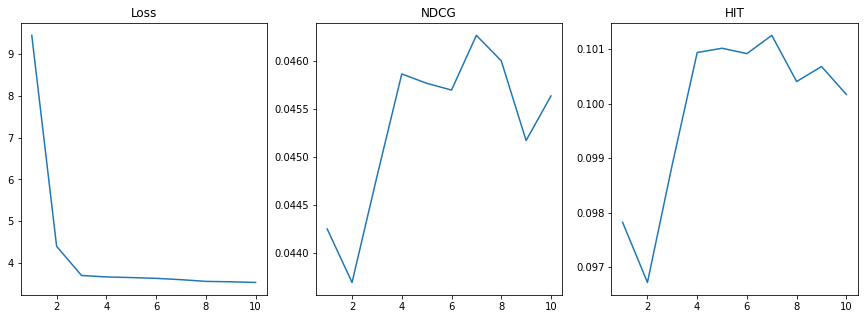

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()
     